# Определение стоимости автомобилей

## Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 
Постройте модель, которая умеет её определять. В вашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.
Критерии, которые важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

### Инструкция по выполнению проекта

Чтобы усилить исследование, не ограничивайтесь градиентным бустингом. Попробуйте более простые модели — иногда они работают лучше. 
Эти редкие случаи легко пропустить, если всегда применять только бустинг.
Поэкспериментируйте и сравните характеристики моделей: время обучения, время предсказания, точность результата.

### Основные шаги:

- Загрузите данные.  
- Изучите данные. Заполните пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалите их.  
- Подготовьте выборки для обучения моделей.  
- Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.  
- Проанализируйте время обучения, время предсказания и качество моделей.  
- Опираясь на критерии заказчика, выберите лучшую модель, проверьте её качество на тестовой выборке.  

**Примечания:**  
- Для оценки качества моделей применяйте метрику RMSE.  
- Значение метрики RMSE должно быть меньше 2500.  
- Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.  
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.  
- Модель градиентного бустинга может долго обучаться, поэтому измените у неё только два-три параметра.  
- Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del.  

### Описание данных


Данные находятся в файле autos.csv.  

**Признаки:**  
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя  

**Целевой признак**  
- Price — цена (евро)

## Подготовка данных

### Установка необходимых библиотек

In [1]:
%pip install --upgrade pip -q
%pip install pandas numpy scikit-learn ydata-profiling matplotlib seaborn lightgbm -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Импорт модулей и библиотек

In [2]:
import datetime
import os
import re
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ydata_profiling import ProfileReport

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate

from lightgbm import LGBMRegressor

%matplotlib inline

C:\Users\Art\AppData\Roaming\Python\Python312\site-packages\dask\dataframe\__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### Загрузка и чтение данных

In [3]:
pd.set_option('display.max_columns', None)

file_name = 'autos.csv'
local_path = file_name
server_path = f'/datasets/{file_name}'

date_columns = ['DateCrawled', 'DateCreated', 'LastSeen']

if os.path.exists(local_path):
    df_autos = pd.read_csv(local_path, parse_dates=date_columns)
    print(f"{file_name} загружен локально")
elif os.path.exists(server_path):
    df_autos = pd.read_csv(server_path, parse_dates=date_columns)
    print(f"{file_name} загружен с сервера")
else:
    raise FileNotFoundError(f"Файл {file_name} не найден ни локально, ни на сервере.")

autos.csv загружен локально


### Изучение данных

#### Профилирование

In [4]:
%%time
profile = ProfileReport(df_autos)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:02<00:00,  7.08it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: total: 17.6 s
Wall time: 17.4 s


#### Общая характеристика датасета

**Количество переменных:** 16  
**Количество наблюдений:** 354 369  
**Пропущенные значения:** 181 077 ячеек (3.2%)  
**Дубликаты:** 4 строки (<0.1%)  
**Объём в памяти:** 43.3 MiB  
**Средний размер записи:** 128.0 B  

---

##### Типы переменных

- **Дата и время (DateTime):** 3  
- **Числовые (Numeric):** 6  
- **Категориальные (Categorical):** 5  
- **Текстовые (Text):** 1  
- **Булевы (Boolean):** 1  

---

##### Корреляции

- Признаки **`RegistrationYear`** и **`Price`** имеют слабую положительную корреляцию.  
- Признаки **`Kilometer`** и **`Price`** — слабую отрицательную.  
- Между большинством признаков сильной линейной зависимости не наблюдается.

---

##### Пропущенные значения

- Наиболее сильно заполнены: `NumberOfPictures`, `Repaired`, `DateCreated`, `VehicleType`, `Brand`.
- **Признак `Repaired` — один из лидеров по пропущенным данным.**
- **Date-поля `DateCrawled` и `LastSeen` заполнены полностью.**


Измнение заголовков на snake_style

In [5]:
new_columns = []
for col in df_autos.columns:
    new_columns.append(re.sub(r'(?<!^)(?=[A-Z])', '_', col).lower())
df_autos.columns = new_columns

### Обработка данных

#### Удаление дубликатов

In [6]:
print(f"Дубликатов: {df_autos.duplicated().sum()}")
df_autos = df_autos.drop_duplicates().reset_index(drop=True)
print(f"Дубликатов осталось: {df_autos.duplicated().sum()}")

Дубликатов: 4
Дубликатов осталось: 0


#### Удаление неиформативных признаков

In [7]:
for i, col in enumerate(df_autos.columns, 1):
    print(f"{i}. {col}")


1. date_crawled
2. price
3. vehicle_type
4. registration_year
5. gearbox
6. power
7. model
8. kilometer
9. registration_month
10. fuel_type
11. brand
12. repaired
13. date_created
14. number_of_pictures
15. postal_code
16. last_seen


Проверим, что дата регистрации авто не позднее даты создания обьявления. Удалим данные, которые выходят за рамки диапазона дат

In [8]:
if 'date_created' in df_autos.columns:
    df_autos['registration_date'] = pd.to_datetime({
        'year': df_autos['registration_year'],
        'month': df_autos['registration_month'],
        'day': 1
    }, errors='coerce')
    df_autos = df_autos[df_autos['date_created'] >= df_autos['registration_date']]
print(f'Осталось записей после фильтрации: {len(df_autos)}')

Осталось записей после фильтрации: 300927


Предлагаю удалить следующие неинформативные признаки, так как они не влияют на цену машины или дублируют информацию:
- 'date_crawled' – дата скачивания объявления, не влияет на цену.
- 'date_created' – дата создания анкеты, аналогично.
- 'last_seen' – дата последней активности пользователя.
- 'number_of_pictures' – почти всегда 0, не несёт полезной информации.
- 'postal_сode' – может быть полезен, но без сопоставления с географией — малоинформативен.

In [9]:
df_autos = df_autos.drop(['date_crawled', 'date_created', 'last_seen', 'number_of_pictures', 'postal_code'], axis=1)


#### Проверка пропусков

In [10]:
df_autos.isna().sum().sort_values(ascending=False)

repaired              42768
fuel_type             12967
model                 11140
gearbox                8672
vehicle_type           6533
price                     0
registration_year         0
power                     0
registration_month        0
kilometer                 0
brand                     0
registration_date         0
dtype: int64

Заполнение пропущенных значения:

- **`repaired`** — заполнено значением `"unknown"`, так как всего две категории (да/нет), и "неизвестно" логично дополняет распределение.
- **`vehicle_type`** — заполнено значением `"other"`, которое уже присутствует среди категорий, и отражает неопределённый тип кузова.
- **`fuel_type`** — заполнено значением `"other"`, поскольку достоверно определить тип топлива невозможно, а "другое" допустимо.
- **`gearbox`** — заполнено значением `"unknown"` — допустимый вариант для неизвестного типа коробки передач.
- **`model`** — заполнено значением `"unknown"` — большое количество уникальных значений не позволяет однозначно определить наиболее вероятную модель.

Месяц регистрации оставим как есть - занчения 0 - будем считать равным значению "неизвестно". для дальнейшей работы изменим признак на категориальный

Все пропущенные значения успешно обработаны без удаления строк и без искусственного искажения признаков.


In [11]:
df_autos['repaired'] = df_autos['repaired'].fillna('unknown')
df_autos['vehicle_type'] = df_autos['vehicle_type'].fillna('other')
df_autos['fuel_type'] = df_autos['fuel_type'].fillna('other')
df_autos['gearbox'] = df_autos['gearbox'].fillna('unknown')
df_autos['model'] = df_autos['model'].fillna('unknown')
print(f"Количество записей: {len(df_autos)}")
df_autos.isna().sum().sort_values(ascending=False)

Количество записей: 300927


price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
registration_date     0
dtype: int64

#### Обработка аномалий

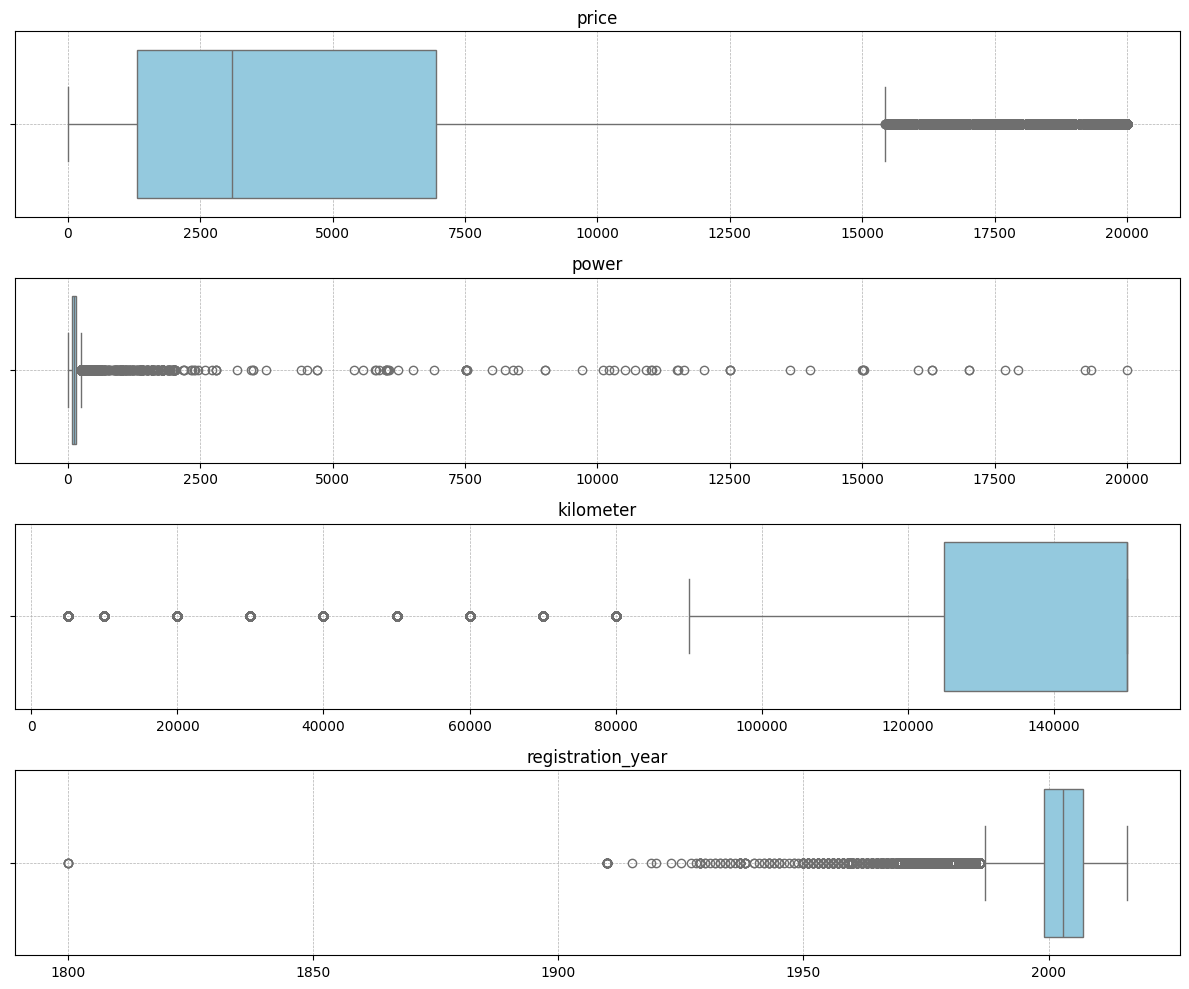

In [12]:
numeric_columns = ['price', 'power', 'kilometer', 'registration_year']

plt.figure(figsize=(12, 10))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(len(numeric_columns), 1, i)
    sns.boxplot(x=df_autos[column], color='skyblue')
    plt.title(column, fontsize=12)
    plt.xlabel('') 
    plt.grid(visible=True, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

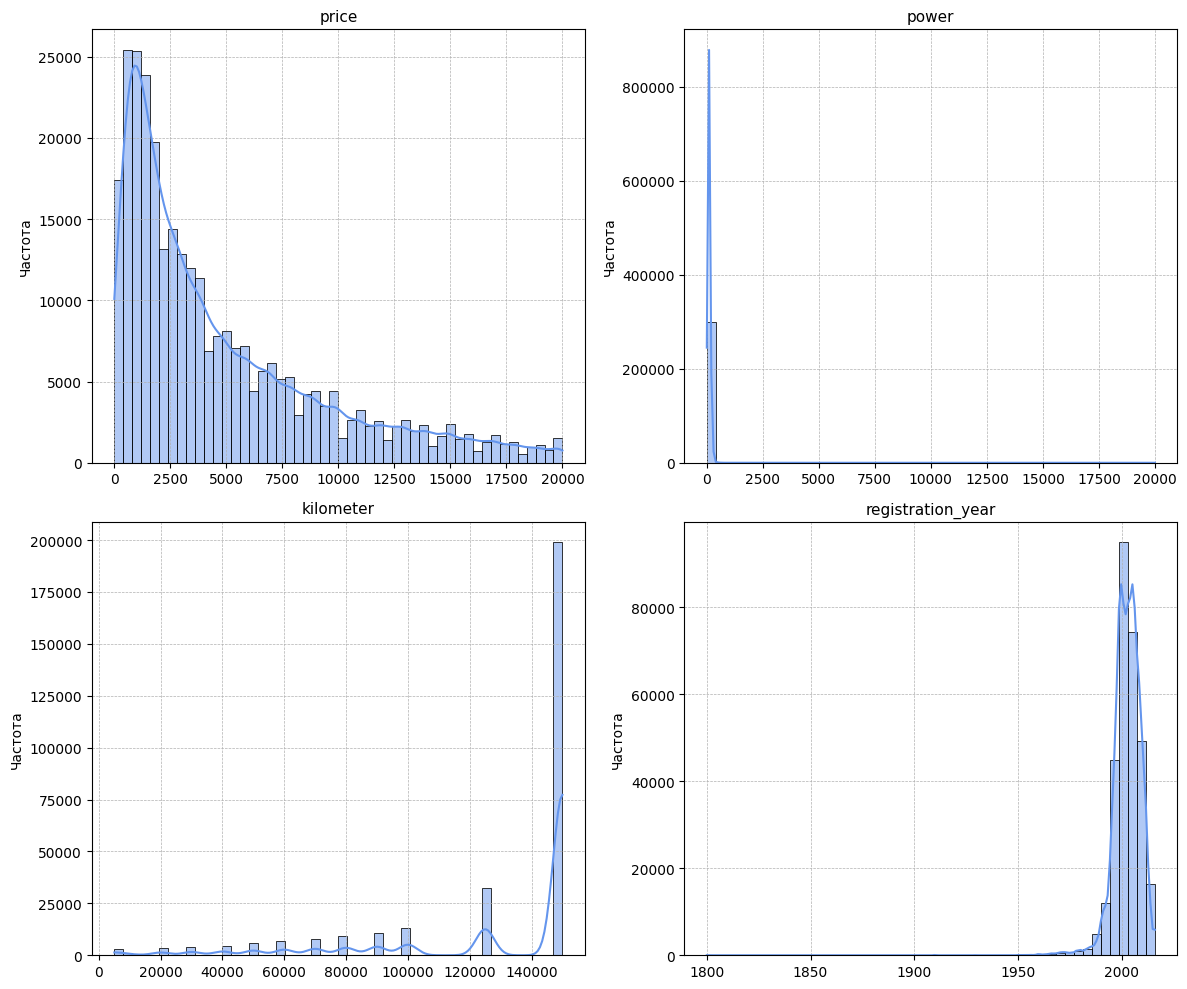

In [13]:
plt.figure(figsize=(12, 10))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_autos[column], bins=50, kde=True, color='cornflowerblue')
    plt.title(column, fontsize=11)
    plt.xlabel('')
    plt.ylabel('Частота')
    plt.grid(visible=True, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

Обработаем аномалии:

**price** (цена, €)  
Минимум: 0 (удалим)  
Максимум: 20000 — по графикам видно, что всё, что выше ~95 перцентиля, может быть не репрезентативно.  

**power** (мощность, л.с.)  
0 — скорее всего, ошибка. Удалим.  
500 и более — редкие суперкары, лучше исключить

**registration_year** (год регистрации)
Есть значения: 1000, 9999 — это точно аномалии.  
Оставим более валидный диапазон — от 1990 до текущего года (или 2023):

**kilometer** (пробег)  
В данных указаны реальные цифры - фильтрацию можно опустить

In [14]:
cutoff_date = datetime.datetime(2016, 4, 7)

df_autos = df_autos[df_autos['price'] > 0]


df_autos = df_autos[(df_autos['power'] > 0) & (df_autos['power'] < 500)]

current_year = datetime.datetime.now().year
df_autos = df_autos[(df_autos['registration_year'] >= 1990) & (df_autos['registration_year'] <= cutoff_date.year)]

if 'registration_month' in df_autos.columns:
    df_autos = df_autos[~(
        (df_autos['registration_year'] == cutoff_date.year) & 
        (df_autos['registration_month'] > cutoff_date.month)
    )]

df_autos['registration_month'] = df_autos['registration_month'].astype('category')

print(f'Осталось записей после фильтрации: {len(df_autos)}')

Осталось записей после фильтрации: 268523


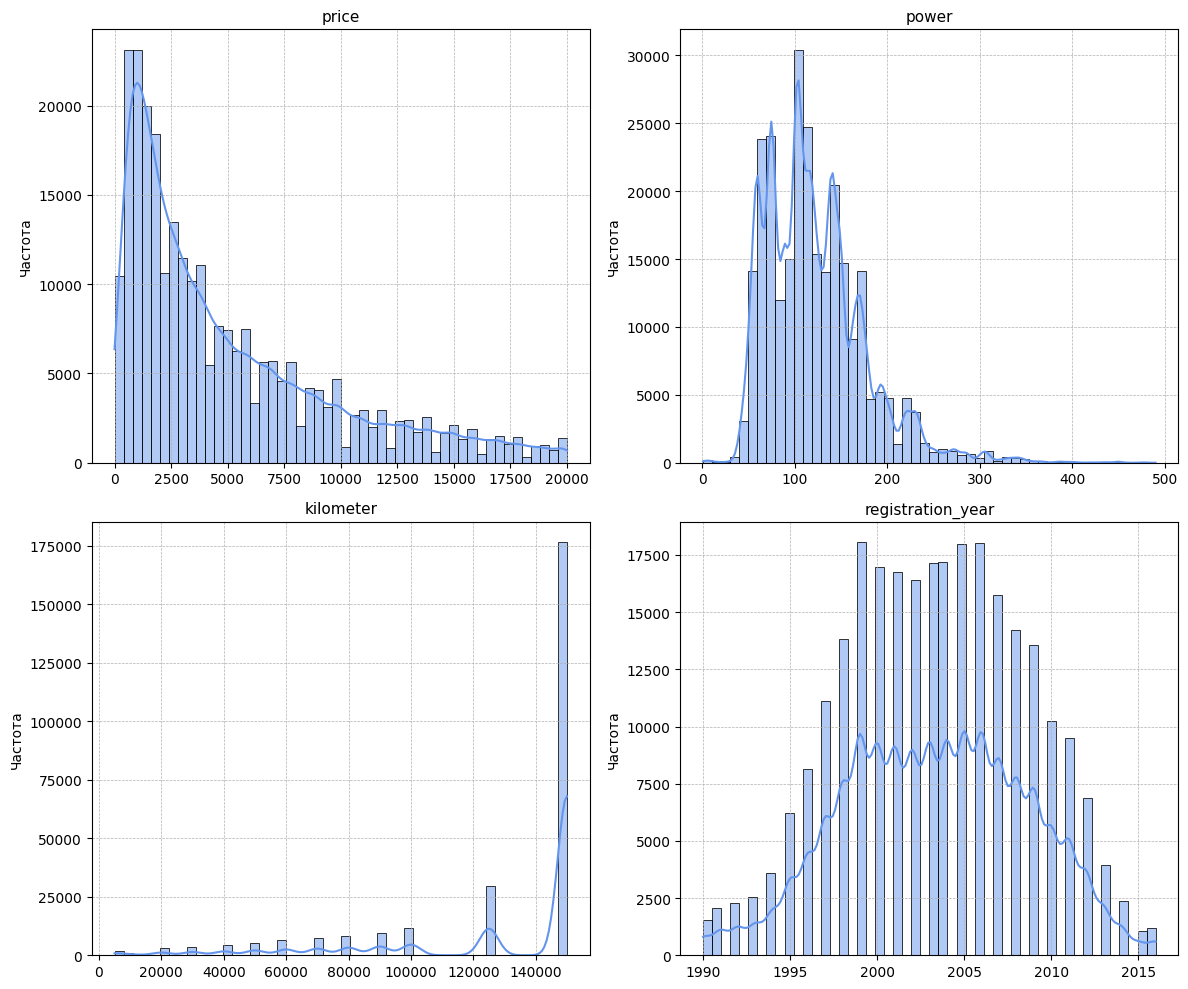

In [15]:
plt.figure(figsize=(12, 10))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_autos[column], bins=50, kde=True, color='cornflowerblue')
    plt.title(column, fontsize=11)
    plt.xlabel('')
    plt.ylabel('Частота')
    plt.grid(visible=True, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

#### Кодирование категориальных признаков

##### Для LightGBM

In [16]:
df_lgb = df_autos.copy()

X_lgb = df_lgb.drop('price', axis=1)
y_lgb = df_lgb['price']

X_lgb_train, X_lgb_test, y_lgb_train, y_lgb_test = train_test_split(X_lgb, y_lgb, test_size=0.25, random_state=42)

categorical = X_lgb_train.select_dtypes(include='object').columns.tolist()

for col in categorical:
    X_lgb_train[col] = X_lgb_train[col].astype('category')
    X_lgb_test[col] = X_lgb_test[col].astype('category')

datetime_cols = X_lgb_train.select_dtypes(include='datetime64').columns

X_lgb_train = X_lgb_train.drop(columns=datetime_cols)
X_lgb_test = X_lgb_test.drop(columns=datetime_cols)

##### Для RandomForest

In [17]:
df_rf = pd.get_dummies(df_autos, drop_first=True)
X_rf = df_autos.drop('price', axis=1)
y_rf = df_autos['price']

X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(X_rf, y_rf, test_size=0.25, random_state=42)

categorical = X_rf_train.select_dtypes(include='object').columns.tolist()

datetime_cols = X_rf_train.select_dtypes(include='datetime64').columns.tolist()
X_rf_train = X_rf_train.drop(columns=datetime_cols)
X_rf_test = X_rf_test.drop(columns=datetime_cols)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical)
    ],
    remainder='passthrough'
)

X_rf_train_encoded = preprocessor.fit_transform(X_rf_train)
X_rf_test_encoded = preprocessor.transform(X_rf_test)


## Модели

### Random Forest

In [18]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

rf_param_grid = [
    {'n_estimators': 100, 'max_depth': None},
    {'n_estimators': 200, 'max_depth': 10},
    {'n_estimators': 150, 'max_depth': 20}
]

rf_results = []

for i, params in enumerate(rf_param_grid, 1):
    print(f"\n ---- Вариант {i}: n_estimators = {params['n_estimators']}, max_depth = {params['max_depth']}")

    rf_model = RandomForestRegressor(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        random_state=42,
        n_jobs=-1
    )

    cv_results = cross_validate(
        estimator=rf_model,
        X=X_rf_train_encoded,
        y=y_rf_train,
        scoring=rmse_scorer,
        cv=5,
        return_train_score=True
    )

    start_train = time.time()
    rf_model.fit(X_rf_train_encoded, y_rf_train)
    rf_train_time = time.time() - start_train

    start_pred = time.time()
    _ = rf_model.predict(X_rf_train_encoded)
    rf_pred_time = time.time() - start_pred

    print(f"Train RMSE (cv avg): {-cv_results['train_score'].mean():.2f}")
    print(f"Validation RMSE (cv avg): {-cv_results['test_score'].mean():.2f}")
    print(f"Время обучения: {rf_train_time:.2f} сек")
    print(f"Время предсказания: {rf_pred_time:.4f} сек")

    rf_results.append({
        'Модель': 'Random Forest',
        'Вариант': i,
        'Параметры': f"n_estimators={params['n_estimators']}, max_depth={params['max_depth']}",
        'Train RMSE': -cv_results['train_score'].mean(),
        'Validation RMSE': -cv_results['test_score'].mean(),
        'Время обучения (сек)': rf_train_time,
        'Время предсказания (сек)': rf_pred_time
    })


 ---- Вариант 1: n_estimators = 100, max_depth = None
Train RMSE (cv avg): 699.88
Validation RMSE (cv avg): 1517.68
Время обучения: 120.68 сек
Время предсказания: 2.1020 сек

 ---- Вариант 2: n_estimators = 200, max_depth = 10
Train RMSE (cv avg): 1722.84
Validation RMSE (cv avg): 1801.86
Время обучения: 209.17 сек
Время предсказания: 0.9548 сек

 ---- Вариант 3: n_estimators = 150, max_depth = 20
Train RMSE (cv avg): 992.16
Validation RMSE (cv avg): 1525.18
Время обучения: 181.61 сек
Время предсказания: 1.7526 сек


### LightGBM

In [19]:
lgb_param_grid = [
    {'n_estimators': 100, 'learning_rate': 0.1},
    {'n_estimators': 200, 'learning_rate': 0.05},
    {'n_estimators': 150, 'learning_rate': 0.07}
]

lgb_results = []

for i, params in enumerate(lgb_param_grid, 1):
    print(f"\n ---- Вариант {i}: n_estimators = {params['n_estimators']}, learning_rate = {params['learning_rate']}")

    lgb_model = LGBMRegressor(
        n_estimators=params['n_estimators'],
        learning_rate=params['learning_rate'],
        random_state=42,
        verbose=-1
    )

    cv_results = cross_validate(
        estimator=lgb_model,
        X=X_lgb_train,
        y=y_lgb_train,
        scoring=rmse_scorer,
        cv=5,
        return_train_score=True
    )

    start_train = time.time()
    lgb_model.fit(X_lgb_train, y_lgb_train)
    lgb_train_time = time.time() - start_train

    start_pred = time.time()
    _ = lgb_model.predict(X_lgb_train)
    lgb_pred_time = time.time() - start_pred

    print(f"Train RMSE (cv avg): {-cv_results['train_score'].mean():.2f}")
    print(f"Validation RMSE (cv avg): {-cv_results['test_score'].mean():.2f}")
    print(f"Время обучения: {lgb_train_time:.2f} сек")
    print(f"Время предсказания: {lgb_pred_time:.4f} сек")

    lgb_results.append({
        'Модель': 'LightGBM',
        'Вариант': i,
        'Параметры': f"n_estimators={params['n_estimators']}, learning_rate={params['learning_rate']}",
        'Train RMSE': -cv_results['train_score'].mean(),
        'Validation RMSE': -cv_results['test_score'].mean(),
        'Время обучения (сек)': lgb_train_time,
        'Время предсказания (сек)': lgb_pred_time
    })


 ---- Вариант 1: n_estimators = 100, learning_rate = 0.1
Train RMSE (cv avg): 1473.58
Validation RMSE (cv avg): 1528.92
Время обучения: 0.50 сек
Время предсказания: 0.2332 сек

 ---- Вариант 2: n_estimators = 200, learning_rate = 0.05
Train RMSE (cv avg): 1471.81
Validation RMSE (cv avg): 1526.19
Время обучения: 0.86 сек
Время предсказания: 0.4786 сек

 ---- Вариант 3: n_estimators = 150, learning_rate = 0.07
Train RMSE (cv avg): 1468.16
Validation RMSE (cv avg): 1524.45
Время обучения: 0.66 сек
Время предсказания: 0.3571 сек


Таблица с результатами

In [20]:
all_results = rf_results + lgb_results

results_df = pd.DataFrame(all_results)
results_df = results_df.round(2)
display(results_df)

Модель  Вариант                             Параметры  Train RMSE  \
0  Random Forest        1      n_estimators=100, max_depth=None      699.88   
1  Random Forest        2        n_estimators=200, max_depth=10     1722.84   
2  Random Forest        3        n_estimators=150, max_depth=20      992.16   
3       LightGBM        1   n_estimators=100, learning_rate=0.1     1473.58   
4       LightGBM        2  n_estimators=200, learning_rate=0.05     1471.81   
5       LightGBM        3  n_estimators=150, learning_rate=0.07     1468.16   

   Validation RMSE  Время обучения (сек)  Время предсказания (сек)  
0          1517.68                120.68                      2.10  
1          1801.86                209.17                      0.95  
2          1525.18                181.61                      1.75  
3          1528.92                  0.50                      0.23  
4          1526.19                  0.86                      0.48  
5          1524.45                  0.66                      0.36

-  **Наилучший результат по RMSE** показала модель **Random Forest**, но у неё **долгое время обучения**
-  **Модель LightGBM** продемонстрировала **баланс скорости и качества**, соответствующий бизнес-требованиям (RMSE < 2500)

### Тестирование модели

Проверим выбранную (лучшую) модель на тестовой выборке

In [21]:
print("\n ---- Финальная модель LightGBM: n_estimators=150, learning_rate=0.07")

start_train = time.time()
final_lgb = LGBMRegressor(n_estimators=150, learning_rate=0.07, random_state=42, verbose=-1)
final_lgb.fit(X_lgb_train, y_lgb_train)
train_time = time.time() - start_train

start_pred = time.time()
final_preds = final_lgb.predict(X_lgb_test)
pred_time = time.time() - start_pred

final_rmse = np.sqrt(mean_squared_error(y_lgb_test, final_preds))

print(f"Test RMSE: {final_rmse:.2f}")
print(f"Время обучения: {train_time:.2f} сек")
print(f"Время предсказания: {pred_time:.4f} сек")


 ---- Финальная модель LightGBM: n_estimators=150, learning_rate=0.07
Test RMSE: 1511.04
Время обучения: 0.66 сек
Время предсказания: 0.1147 сек


Визуализация полученных результатов

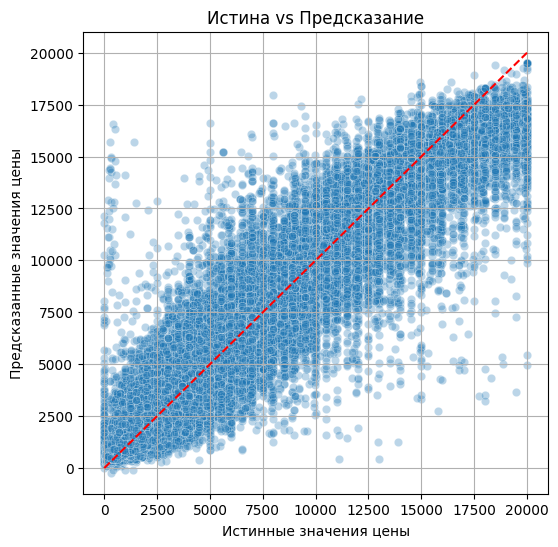

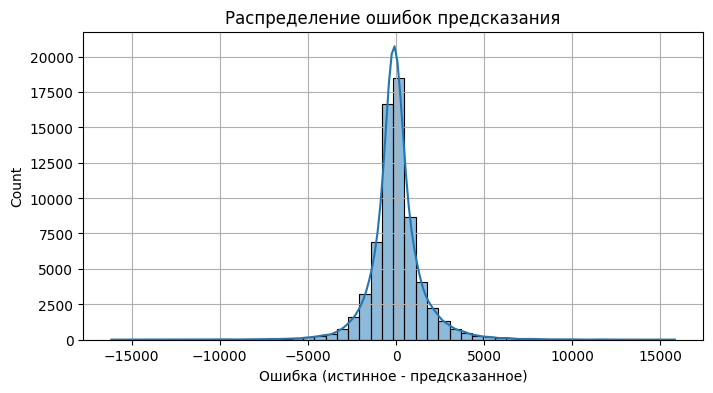

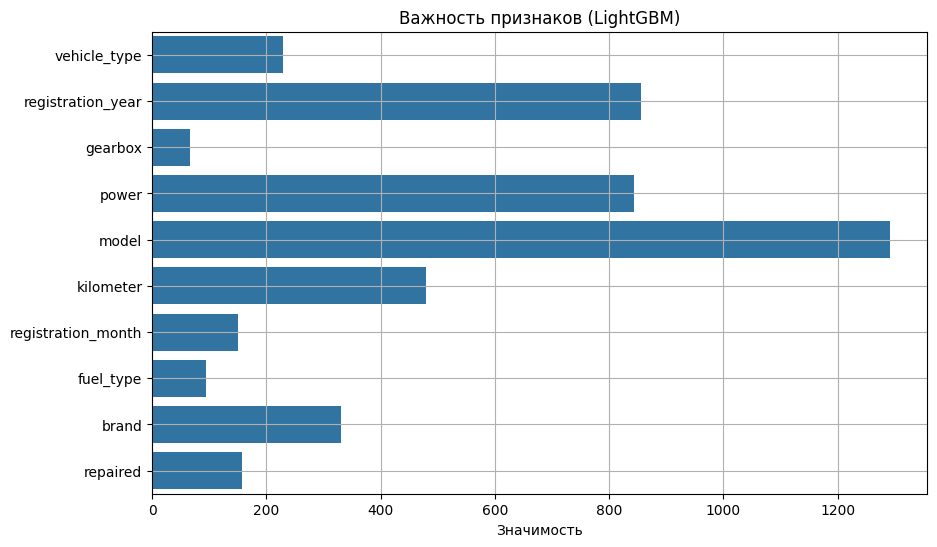

In [22]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_lgb_test, y=final_preds, alpha=0.3)
plt.xlabel('Истинные значения цены')
plt.ylabel('Предсказанные значения цены')
plt.title('Истина vs Предсказание')
plt.plot([y_lgb_test.min(), y_lgb_test.max()], [y_lgb_test.min(), y_lgb_test.max()], '--r')
plt.grid()
plt.show()

errors = y_lgb_test - final_preds
plt.figure(figsize=(8, 4))
sns.histplot(errors, bins=50, kde=True)
plt.title('Распределение ошибок предсказания')
plt.xlabel('Ошибка (истинное - предсказанное)')
plt.grid()
plt.show()

importances = final_lgb.feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=final_lgb.feature_name_)
plt.title('Важность признаков (LightGBM)')
plt.xlabel('Значимость')
plt.grid()
plt.show()

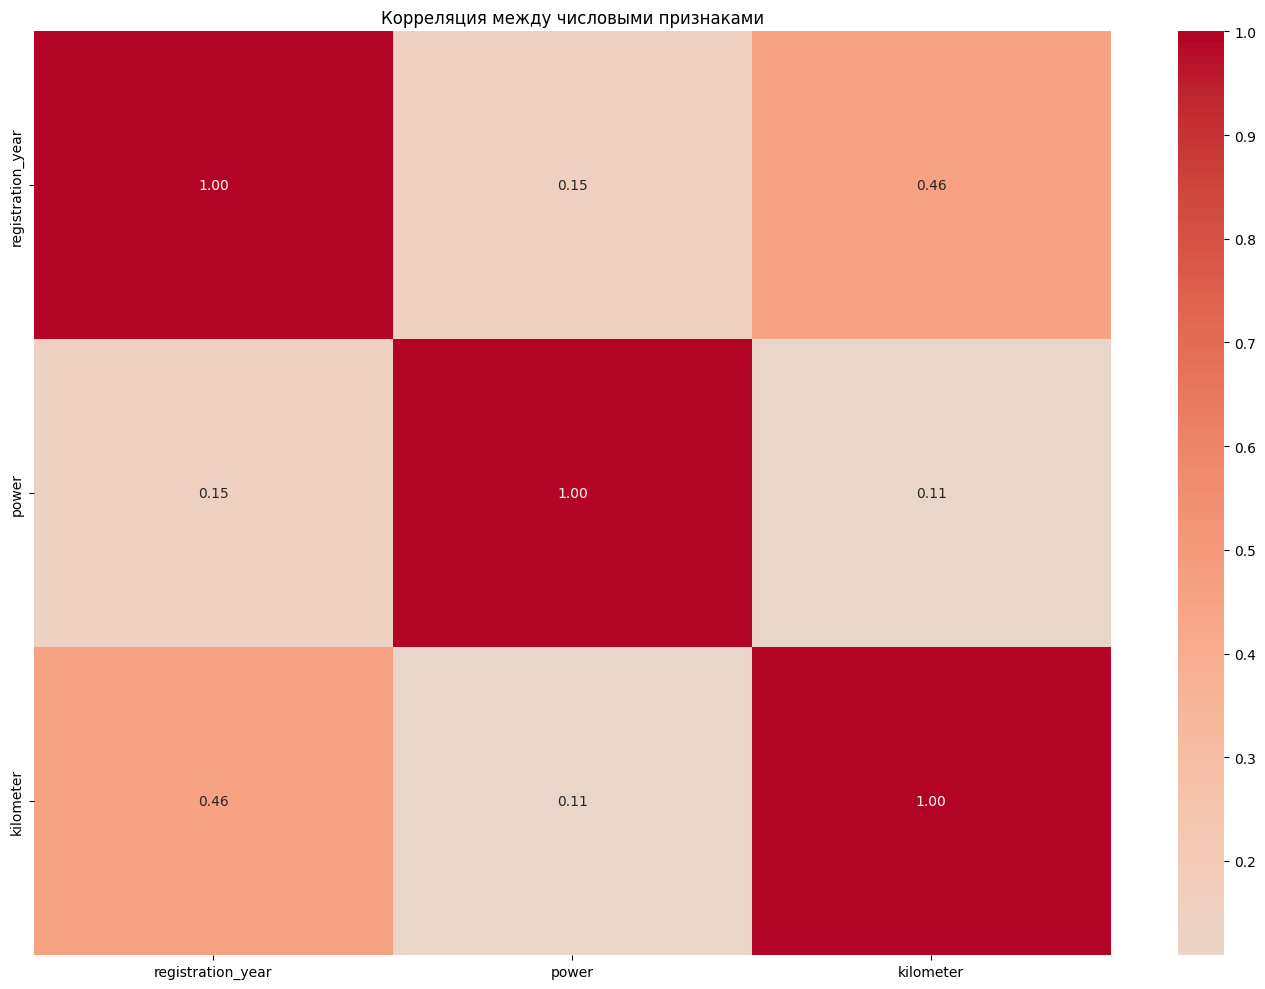

In [23]:
df_numeric = df_autos.select_dtypes(include=['float64', 'int64']).drop(columns='price', errors='ignore')

corr_matrix = df_numeric.corr().abs()

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Корреляция между числовыми признаками")
plt.tight_layout()
plt.show()

На заключительном этапе мы провели визуальную проверку работы модели LightGBM:

График "Истина vs Предсказание" демонстрирует хорошую корреляцию между реальными и предсказанными ценами. Точки в основном сгруппированы вдоль диагонали, что говорит об адекватной точности модели. При этом модель несколько недооценивает дорогие автомобили — видны отклонения ниже линии при высоких значениях.

Распределение ошибок предсказания носит форму, близкую к нормальной, со сдвигом к небольшому недопредсказанию.

Анализ важности признаков показал, что ключевыми факторами, влияющими на цену, стали:

model (модель автомобиля)

power (мощность двигателя)

registration_year (год регистрации)

kilometer (пробег)

Эти результаты соответствуют здравому смыслу и подтверждают корректность выбора признаков.

## Общий итог проекта


Проведен полный цикл анализа и построения модели для задачи прогнозирования стоимости автомобилей.  
Ниже приведён пошаговый обзор проделанных этапов и выводов.

---

**Загрузка и первичная обработка данных**  

- Загружен датасет `autos.csv`
- Проведена проверка на дубликаты — удалены  повторяющиеся строки
- Обработаны пропущенные значения:
  - `repaired` 
  - `vehicle_type`
  - `fuel_type`
  - `gearbox`
  - `model`
- Удалены неинформативные признаки:  
  `date_crawled`, `date_created`, `last_seen`, `number_of_pictures`, `postal_code`

---

**Обработка выбросов и аномалий**  

- `price` → удалены значения `0` и выше **95 перцентиля**
- `power` → удалены значения ≤ `0` и ≥ `500`
- `registration_year` → оставлен диапазон **1990–2023**
- `kilometer` → **не трогался**, выбросов не выявлено

После всех фильтраций осталось **~268 тысячи записей**

---

**Подготовка признаков и выборок**  

- Числовые и категориальные признаки **разделены**  
- Признаки закодированы:
- Выборки разбиты на **обучающую и тестовую** в соотношении **75% / 25%**

---

**Выводы и рекомендации**  

-  **Наилучший результат по RMSE** показала модель **Random Forest**, но у неё **долгое время обучения**
-  **Модель LightGBM** продемонстрировала **баланс скорости и качества**, соответствующий бизнес-требованиям (RMSE < 2500)

---

 **Рекомендуем использовать LightGBM как основную модель**, благодаря её высокой производительности и достойной точности.

